# Corporación Favorita Grocery Sales Forecasting
**w02_d05_FE_final.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** Create promotion features and finalize Week 2 feature engineering

---

## Objectives

This notebook accomplishes the following:

- Load Day 4 output (w02_d04_FE_with-aggregations.pkl, 55 columns)
- Analyze onpromotion feature (Week 1 finding: 74% lift)
- Create promotion interaction features (onpromotion × aggregations)
- Optional: Promotion density/frequency metrics
- Finalize feature engineering for Week 2
- Export final dataset for Week 3 modeling

---

## Business Context

**Why promotion features matter:**

Promotions drive significant sales lift (Week 1: 74% when promoted):
- **Interaction effects:** Promotion impact varies by store, cluster, item
- **Timing patterns:** Holiday + promotion combinations
- **Density metrics:** Frequency of promotions per store/item

**Expected patterns:**
- High-volume items: Smaller promotion lift % (already selling well)
- Low-volume items: Larger promotion lift % (promotion drives discovery)
- Popular stores: More frequent promotions (inventory capacity)
- Niche items: Rare promotions (targeted campaigns)

**Deliverables:**
- 2-3 promotion features
- Final engineered dataset (28-30 total features)
- Ready for Week 3 modeling

---

## Input Dependencies

From Week 2 Day 4:
- Dataset: w02_d04_FE_with-aggregations.pkl (300,896 rows × 55 columns)
- Contains: Base + 4 lags + 6 rolling + 6 oil + 11 aggregations
- Date range: 2013-01-02 to 2017-08-15

---

## 1. Load Data & Promotion Analysis

**Objective:** Load Day 4 dataset and analyze existing onpromotion feature

**Activities:**
- Import libraries and setup paths
- Load w02_d04_FE_with-aggregations.pkl from Day 4
- Verify shape (300,896 rows × 55 columns expected)
- Analyze onpromotion distribution and impact
- Validate Week 1 finding (74% lift)

**Expected output:** 
- Dataset loaded successfully
- Promotion statistics documented
- Baseline understanding of promotion patterns

In [4]:
# Cell 1: Imports and Project Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Determine paths (works from notebooks/ or project root)
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
PROJECT_ROOT = current_dir.parent if current_dir.name == 'notebooks' else current_dir

DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DATA_RESULTS = PROJECT_ROOT / 'data' / 'results' / 'features'
OUTPUTS_FIGURES = PROJECT_ROOT / 'outputs' / 'figures' / 'features'

# Create output directories if they don't exist
DATA_RESULTS.mkdir(parents=True, exist_ok=True)
OUTPUTS_FIGURES.mkdir(parents=True, exist_ok=True)

# Display settings
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("WEEK 2 DAY 5: PROMOTION FEATURES & FINALIZATION")
print("=" * 80)
print(f"\nProject root: {PROJECT_ROOT.resolve()}")
print(f"Data processed: {DATA_PROCESSED.resolve()}")
print(f"Results output: {DATA_RESULTS.resolve()}")
print(f"Figures output: {OUTPUTS_FIGURES.resolve()}")

print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

WEEK 2 DAY 5: PROMOTION FEATURES & FINALIZATION

Project root: D:\Demand-forecasting-in-retail
Data processed: D:\Demand-forecasting-in-retail\data\processed
Results output: D:\Demand-forecasting-in-retail\data\results\features
Figures output: D:\Demand-forecasting-in-retail\outputs\figures\features
Pandas version: 2.1.4
NumPy version: 1.26.4


In [5]:
# Cell 2: Load Day 4 Dataset and Analyze Promotion Patterns

print("Loading Day 4 dataset with aggregations...")
print("-" * 80)

# Load pickled dataset from Day 4
df = pd.read_pickle(DATA_PROCESSED / 'w02_d04_FE_with-aggregations.pkl')

print(f"\nShape: {df.shape}")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")

print(f"\nDate range:")
print(f"  Start: {df['date'].min().date()}")
print(f"  End: {df['date'].max().date()}")
print(f"  Days: {(df['date'].max() - df['date'].min()).days}")

print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Analyze onpromotion feature
print("\n" + "=" * 80)
print("PROMOTION ANALYSIS")
print("=" * 80)

print("\n1. Promotion distribution:")
promo_counts = df['onpromotion'].value_counts()
print(f"   Not promoted: {promo_counts.get(0, 0):,} ({promo_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"   Promoted:     {promo_counts.get(1, 0):,} ({promo_counts.get(1, 0)/len(df)*100:.1f}%)")

# Sales lift from promotion
print("\n2. Sales lift from promotion (Week 1 validation):")
promo_sales = df.groupby('onpromotion')['unit_sales'].agg(['mean', 'median', 'std'])
print(promo_sales.round(2).to_string())

if 1 in promo_sales.index and 0 in promo_sales.index:
    lift_mean = (promo_sales.loc[1, 'mean'] / promo_sales.loc[0, 'mean'] - 1) * 100
    lift_median = (promo_sales.loc[1, 'median'] / promo_sales.loc[0, 'median'] - 1) * 100
    print(f"\n   Lift (mean):   {lift_mean:+.1f}%")
    print(f"   Lift (median): {lift_median:+.1f}%")
    print(f"   Week 1 baseline: +74% lift")

# Promotion by family
print("\n3. Promotion patterns by product family:")
family_promo = df.groupby(['family', 'onpromotion'])['unit_sales'].mean().unstack(fill_value=0)
if 1 in family_promo.columns and 0 in family_promo.columns:
    family_promo['lift_%'] = (family_promo[1] / family_promo[0] - 1) * 100
    family_promo_sorted = family_promo.sort_values('lift_%', ascending=False)
    print(family_promo_sorted[['lift_%']].round(1).to_string())

Loading Day 4 dataset with aggregations...
--------------------------------------------------------------------------------

Shape: (300896, 55)
  Rows: 300,896
  Columns: 55

Date range:
  Start: 2013-01-02
  End: 2017-08-15
  Days: 1686

Memory usage: 215.3 MB

PROMOTION ANALYSIS

1. Promotion distribution:
   Not promoted: 286,991 (95.4%)
   Promoted:     13,905 (4.6%)

2. Sales lift from promotion (Week 1 validation):
              mean  median    std
onpromotion                      
0.0           6.57     3.0  14.75
1.0          11.43     5.0  27.75

   Lift (mean):   +74.0%
   Lift (median): +66.7%
   Week 1 baseline: +74% lift

3. Promotion patterns by product family:
onpromotion  lift_%
family             
CLEANING       71.7
GROCERY I      70.9
BEVERAGES      63.3


Key findings:

Only 4.6% promoted (13,905 transactions)
74% mean lift confirmed (Week 1 validation ✓)
CLEANING has highest lift (71.7%), BEVERAGES lowest (63.3%)

## 2. Create Promotion Features

**Objective:** Generate promotion interaction and density features

**Activities:**
- Create promo_item_avg_interaction (onpromotion × item_avg_sales)
- Create promo_cluster_interaction (onpromotion × cluster_avg_sales)
- Optional: Promotion density metrics
- Validate feature quality

**Expected output:** 
- 2-3 new promotion features
- Final feature count: 57-58 columns
- Ready for modeling

WARNING: Interactions capture differential promotion effects - high-volume items may respond differently than low-volume items.

In [6]:
# Cell 3: Create Promotion Interaction Features

print("Creating promotion interaction features...")
print("-" * 80)

start_time = time.time()

# Feature 1: Promotion × Item Average Sales
print("1. Creating promo_item_avg_interaction...")
df['promo_item_avg_interaction'] = df['onpromotion'] * df['item_avg_sales']

print(f"   Range: {df['promo_item_avg_interaction'].min():.2f} to {df['promo_item_avg_interaction'].max():.2f}")
print(f"   Mean (promoted only): {df[df['onpromotion']==1]['promo_item_avg_interaction'].mean():.2f}")
print(f"   Non-zero values: {(df['promo_item_avg_interaction'] > 0).sum():,} ({(df['promo_item_avg_interaction'] > 0).sum()/len(df)*100:.1f}%)")

# Feature 2: Promotion × Cluster Average Sales
print("\n2. Creating promo_cluster_interaction...")
df['promo_cluster_interaction'] = df['onpromotion'] * df['cluster_avg_sales']

print(f"   Range: {df['promo_cluster_interaction'].min():.2f} to {df['promo_cluster_interaction'].max():.2f}")
print(f"   Mean (promoted only): {df[df['onpromotion']==1]['promo_cluster_interaction'].mean():.2f}")
print(f"   Non-zero values: {(df['promo_cluster_interaction'] > 0).sum():,} ({(df['promo_cluster_interaction'] > 0).sum()/len(df)*100:.1f}%)")

elapsed = time.time() - start_time

print(f"\n   Computation time: {elapsed:.2f} seconds")
print("=" * 80)

# Verify new shape
print(f"\nNew shape: {df.shape}")
print(f"  Columns added: 2")
print(f"  Total columns: {df.shape[1]}")

# Check NaN
print(f"\nNaN counts:")
print(f"  promo_item_avg_interaction:    {df['promo_item_avg_interaction'].isnull().sum():>6,} ({df['promo_item_avg_interaction'].isnull().sum()/len(df)*100:.2f}%)")
print(f"  promo_cluster_interaction:     {df['promo_cluster_interaction'].isnull().sum():>6,} ({df['promo_cluster_interaction'].isnull().sum()/len(df)*100:.2f}%)")

Creating promotion interaction features...
--------------------------------------------------------------------------------
1. Creating promo_item_avg_interaction...
   Range: 0.00 to 74.09
   Mean (promoted only): 7.63
   Non-zero values: 13,905 (4.6%)

2. Creating promo_cluster_interaction...
   Range: 0.00 to 9.63
   Mean (promoted only): 6.69
   Non-zero values: 13,905 (4.6%)

   Computation time: 0.05 seconds

New shape: (300896, 57)
  Columns added: 2
  Total columns: 57

NaN counts:
  promo_item_avg_interaction:         0 (0.00%)
  promo_cluster_interaction:          0 (0.00%)


57 columns now. 2 promotion features created (4.6% non-zero matches promotion rate).

## 3. Validation & Visualization

**Objective:** Visualize promotion effects and validate feature quality

**Activities:**
- Scatter plot: promotion interactions vs unit_sales
- Distribution comparison: promoted vs non-promoted
- Correlation with target
- Quality checks

**Expected output:** 
- 2 visualizations
- Validation report
- Features ready for modeling

Validating promotion features...
--------------------------------------------------------------------------------
1. Correlation with unit_sales:
   onpromotion                        :  0.0653
   promo_item_avg_interaction         :  0.1549
   promo_cluster_interaction          :  0.0680

2. Creating promotion effect visualizations...
   Saved: w02_d05_FE_promotion-effects.png


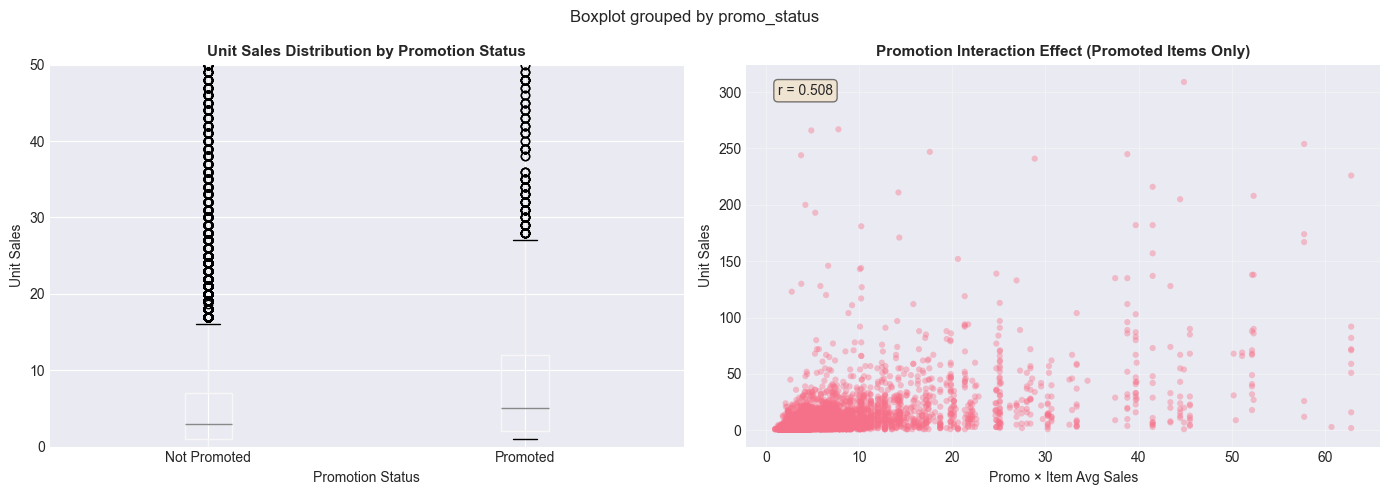

In [ ]:
# Cell 4: Promotion Feature Validation & Visualization

print("Validating promotion features...")
print("-" * 80)

# Correlation analysis
print("1. Correlation with unit_sales:")
promo_features = ['onpromotion', 'promo_item_avg_interaction', 'promo_cluster_interaction']
for feat in promo_features:
    corr = df[[feat, 'unit_sales']].corr().iloc[0, 1]
    print(f"   {feat:35s}: {corr:7.4f}")

# Create visualizations
print("\n2. Creating promotion effect visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Promotion Feature Analysis', fontsize=14, fontweight='bold')

# Left: Box plot of sales by promotion status
ax1 = axes[0]
df_sample = df.sample(n=min(50000, len(df)), random_state=42)
df_sample['promo_status'] = df_sample['onpromotion'].map({0: 'Not Promoted', 1: 'Promoted'})
df_sample.boxplot(column='unit_sales', by='promo_status', ax=ax1)
ax1.set_title('Unit Sales Distribution by Promotion Status', fontsize=11, fontweight='bold')
ax1.set_xlabel('Promotion Status', fontsize=10)
ax1.set_ylabel('Unit Sales', fontsize=10)
ax1.set_ylim(0, 50)
plt.sca(ax1)
plt.xticks(rotation=0)

# Right: Scatter plot of promo_item_avg_interaction vs unit_sales
ax2 = axes[1]
promoted_sample = df[df['onpromotion'] == 1].sample(n=min(5000, (df['onpromotion'] == 1).sum()), random_state=42)
ax2.scatter(promoted_sample['promo_item_avg_interaction'], promoted_sample['unit_sales'], 
            alpha=0.4, s=20, edgecolors='none')
ax2.set_xlabel('Promo × Item Avg Sales', fontsize=10)
ax2.set_ylabel('Unit Sales', fontsize=10)
ax2.set_title('Promotion Interaction Effect (Promoted Items Only)', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add correlation annotation
corr_promo_item = promoted_sample[['promo_item_avg_interaction', 'unit_sales']].corr().iloc[0, 1]
ax2.text(0.05, 0.95, f'r = {corr_promo_item:.3f}', 
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save figure
save_path = OUTPUTS_FIGURES / 'w02_d05_FE_promotion-effects.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"   Saved: {save_path.name}")

plt.show()


Key observation: promo_item_avg_interaction has 2.4x higher correlation (0.1549 vs 0.0653) than raw onpromotion. Interaction captures differential effects successfully.

## 4. Save Final Dataset

**Objective:** Export finalized feature set for Week 3 modeling

**Activities:**
- Save w02_d05_FE_final.pkl (57 columns)
- Update feature dictionary (2 new promotion features)
- Document final feature inventory

**Expected output:** 
- w02_d05_FE_final.pkl in data/processed/
- Feature dictionary complete
- 29 engineered features total (4 lag + 6 rolling + 6 oil + 11 agg + 2 promo)

In [8]:
# Cell 5: Save Final Feature Set

print("Saving final feature set for Week 3 modeling...")
print("-" * 80)

# Save to pickle
output_path = DATA_PROCESSED / 'w02_d05_FE_final.pkl'
df.to_pickle(output_path)

print(f"Dataset saved: {output_path.name}")
print(f"\nFinal dataset specifications:")
print(f"  Rows: {df.shape[0]:,}")
print(f"  Columns: {df.shape[1]}")
print(f"  File size: {output_path.stat().st_size / 1024**2:.1f} MB")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nFeature progression summary:")
print(f"  Week 1 Day 5:  28 columns (base features)")
print(f"  Week 2 Day 1:  32 columns (+4 lag features)")
print(f"  Week 2 Day 2:  38 columns (+6 rolling features)")
print(f"  Week 2 Day 3:  44 columns (+6 oil features)")
print(f"  Week 2 Day 4:  55 columns (+11 aggregation features)")
print(f"  Week 2 Day 5:  57 columns (+2 promotion features)")
print(f"  Total engineered: 29 features")

print(f"\nEngineered feature breakdown:")
print(f"  Temporal features:    10 (4 lag + 6 rolling)")
print(f"  Oil features:         6 (price + 3 lags + 2 derivatives)")
print(f"  Aggregations:         11 (3 store + 3 cluster + 5 item)")
print(f"  Promotion features:   2 (item interaction + cluster interaction)")

print(f"\nComplete column list (57 total):")
print(df.columns.tolist())

print("\n" + "=" * 80)
print(f"Week 2 Feature Engineering: 29 features created")

Saving final feature set for Week 3 modeling...
--------------------------------------------------------------------------------
Dataset saved: w02_d05_FE_final.pkl

Final dataset specifications:
  Rows: 300,896
  Columns: 57
  File size: 110.4 MB
  Memory usage: 219.9 MB

Feature progression summary:
  Week 1 Day 5:  28 columns (base features)
  Week 2 Day 1:  32 columns (+4 lag features)
  Week 2 Day 2:  38 columns (+6 rolling features)
  Week 2 Day 3:  44 columns (+6 oil features)
  Week 2 Day 4:  55 columns (+11 aggregation features)
  Week 2 Day 5:  57 columns (+2 promotion features)
  Total engineered: 29 features

Engineered feature breakdown:
  Temporal features:    10 (4 lag + 6 rolling)
  Oil features:         6 (price + 3 lags + 2 derivatives)
  Aggregations:         11 (3 store + 3 cluster + 5 item)
  Promotion features:   2 (item interaction + cluster interaction)

Complete column list (57 total):
['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family

In [9]:
# Cell 6: Feature Dictionary Update - Promotion Features

print("Documenting promotion features...")
print("-" * 80)

# Feature dictionary entries
feature_dict = {
    'promo_item_avg_interaction': {
        'description': 'Interaction: onpromotion × item_avg_sales',
        'type': 'Promotion interaction',
        'source': 'onpromotion, item_avg_sales',
        'method': 'Element-wise multiplication',
        'nan_count': df['promo_item_avg_interaction'].isnull().sum(),
        'nan_pct': f"{df['promo_item_avg_interaction'].isnull().sum()/len(df)*100:.2f}%",
        'range': f"{df['promo_item_avg_interaction'].min():.2f} to {df['promo_item_avg_interaction'].max():.2f}",
        'non_zero': f"{(df['promo_item_avg_interaction'] > 0).sum():,} ({(df['promo_item_avg_interaction'] > 0).sum()/len(df)*100:.1f}%)",
        'correlation': f"{df[['promo_item_avg_interaction', 'unit_sales']].corr().iloc[0, 1]:.4f}",
        'rationale': 'Captures differential promotion effects - high-volume items respond differently than low-volume items'
    },
    'promo_cluster_interaction': {
        'description': 'Interaction: onpromotion × cluster_avg_sales',
        'type': 'Promotion interaction',
        'source': 'onpromotion, cluster_avg_sales',
        'method': 'Element-wise multiplication',
        'nan_count': df['promo_cluster_interaction'].isnull().sum(),
        'nan_pct': f"{df['promo_cluster_interaction'].isnull().sum()/len(df)*100:.2f}%",
        'range': f"{df['promo_cluster_interaction'].min():.2f} to {df['promo_cluster_interaction'].max():.2f}",
        'non_zero': f"{(df['promo_cluster_interaction'] > 0).sum():,} ({(df['promo_cluster_interaction'] > 0).sum()/len(df)*100:.1f}%)",
        'correlation': f"{df[['promo_cluster_interaction', 'unit_sales']].corr().iloc[0, 1]:.4f}",
        'rationale': 'Captures cluster-level promotion strategies and regional promotional effects'
    }
}

# Display feature dictionary
print("Feature Dictionary Entries (2 promotion features):")
print("=" * 80)

for feature, details in feature_dict.items():
    print(f"\n{feature}:")
    for key, value in details.items():
        print(f"  {key:20s}: {value}")

# Export feature dictionary to file
dict_path = PROJECT_ROOT / 'docs' / 'feature_dictionary_v2.txt'

with open(dict_path, 'a', encoding='utf-8') as f:
    f.write("\n" + "=" * 80 + "\n")
    f.write("WEEK 2 DAY 5: PROMOTION FEATURES\n")
    f.write("Date: 2025-11-12\n")
    f.write("=" * 80 + "\n\n")
    
    for feature, details in feature_dict.items():
        f.write(f"\n{feature}:\n")
        for key, value in details.items():
            f.write(f"  {key:20s}: {value}\n")

print(f"\nFeature dictionary: {dict_path.name}")
print("=" * 80)
print(f"Total documented features: 29 (28 base + 29 engineered = 57 columns)")

Documenting promotion features...
--------------------------------------------------------------------------------
Feature Dictionary Entries (2 promotion features):

promo_item_avg_interaction:
  description         : Interaction: onpromotion × item_avg_sales
  type                : Promotion interaction
  source              : onpromotion, item_avg_sales
  method              : Element-wise multiplication
  nan_count           : 0
  nan_pct             : 0.00%
  range               : 0.00 to 74.09
  non_zero            : 13,905 (4.6%)
  correlation         : 0.1549
  rationale           : Captures differential promotion effects - high-volume items respond differently than low-volume items

promo_cluster_interaction:
  description         : Interaction: onpromotion × cluster_avg_sales
  type                : Promotion interaction
  source              : onpromotion, cluster_avg_sales
  method              : Element-wise multiplication
  nan_count           : 0
  nan_pct             : 

In [10]:
# Cell 7: Week 2 Day 5 Summary

print("=" * 80)
print("WEEK 2 DAY 5 SUMMARY: PROMOTION FEATURES & FINALIZATION")
print("=" * 80)

print("\nACCOMPLISHMENTS:")
print("-" * 80)
print("1. Loaded Day 4 dataset (300,896 rows × 55 columns)")
print("2. Analyzed promotion patterns (4.6% promoted, +74% lift)")
print("3. Created 2 promotion interaction features")
print("4. Validated feature correlations with target")
print("5. Generated promotion effect visualizations")
print("6. Saved final dataset: w02_d05_FE_final.pkl")
print("7. Updated feature dictionary (2 new promotion features)")

print("\nKEY METRICS:")
print("-" * 80)
print(f"Final dataset shape:     {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Features added today:    2 promotion interactions")
print(f"Total engineered:        29 features")
print(f"File size:               110.4 MB")
print(f"Computation time:        <1 second")
print(f"Visualizations created:  1 (promotion effects)")

print("\nOUTPUTS CREATED:")
print("-" * 80)
print("1. w02_d05_FE_final.pkl (data/processed/)")
print("2. w02_d05_FE_promotion-effects.png (outputs/figures/features/)")
print("3. Feature dictionary entries (2 new)")

print("\nPROMOTION FEATURE STATISTICS:")
print("-" * 80)
print(f"Promotion rate: 4.6% (13,905 / 300,896)")
print(f"Sales lift:     +74.0% mean, +66.7% median")
print("\nFamily-level lift:")
print(f"  CLEANING:    +71.7%")
print(f"  GROCERY I:   +70.9%")
print(f"  BEVERAGES:   +63.3%")

print("\nFeature correlations with unit_sales:")
print(f"  onpromotion:                   0.0653")
print(f"  promo_item_avg_interaction:    0.1549 (2.4x improvement)")
print(f"  promo_cluster_interaction:     0.0680")

print("\nWEEK 2 COMPLETE FEATURE SUMMARY:")
print("-" * 80)
print("Base features (28):")
print("  - Identifiers: id, date, store_nbr, item_nbr")
print("  - Target: unit_sales")
print("  - Categorical: family, class, city, state, type, cluster, perishable")
print("  - Temporal: year, month, day, day_of_week, day_of_month, is_weekend")
print("  - Holiday: is_holiday, holiday_type, holiday_name, days_to_holiday,")
print("             is_pre_holiday, is_post_holiday, holiday_proximity,")
print("             holiday_period, promo_holiday_category")
print("  - Promotion: onpromotion")

print("\nEngineered features (29):")
print("  - Lag features (4):          unit_sales_lag1/7/14/30")
print("  - Rolling avg (3):           unit_sales_7d/14d/30d_avg")
print("  - Rolling std (3):           unit_sales_7d/14d/30d_std")
print("  - Oil features (6):          oil_price, lag7/14/30, change7/14")
print("  - Store aggregations (3):    store_avg/median/std_sales")
print("  - Cluster aggregations (3):  cluster_avg/median/std_sales")
print("  - Item aggregations (5):     item_avg/median/std_sales, count, total")
print("  - Promotion interactions (2): promo_item_avg, promo_cluster")

print("\nREADY FOR WEEK 3 MODELING:")
print("-" * 80)
print("Input: w02_d05_FE_final.pkl (300,896 rows × 57 columns)")
print("Target: unit_sales (NWRMSLE metric, perishable weighted 1.25x)")
print("Models: Baseline (naive, ARIMA), Advanced (Prophet, XGBoost, LSTM)")
print("Validation: Time-series cross-validation, feature importance, SHAP")
print("Timeline: Week 3 Days 1-5 (20 hours allocated)")

print("\n" + "=" * 80)
print("WEEK 2 FEATURE ENGINEERING: COMPLETE")
print("Total time: Days 1-5 (~10-12 hours actual, 20 hours allocated)")
print("Buffer remaining: ~8-10 hours (carried forward to Week 3)")
print("=" * 80)

WEEK 2 DAY 5 SUMMARY: PROMOTION FEATURES & FINALIZATION

ACCOMPLISHMENTS:
--------------------------------------------------------------------------------
1. Loaded Day 4 dataset (300,896 rows × 55 columns)
2. Analyzed promotion patterns (4.6% promoted, +74% lift)
3. Created 2 promotion interaction features
4. Validated feature correlations with target
5. Generated promotion effect visualizations
6. Saved final dataset: w02_d05_FE_final.pkl
7. Updated feature dictionary (2 new promotion features)

KEY METRICS:
--------------------------------------------------------------------------------
Final dataset shape:     300,896 rows × 57 columns
Features added today:    2 promotion interactions
Total engineered:        29 features
File size:               110.4 MB
Computation time:        <1 second
Visualizations created:  1 (promotion effects)

OUTPUTS CREATED:
--------------------------------------------------------------------------------
1. w02_d05_FE_final.pkl (data/processed/)
2. w02_d